In [1]:
import pandas as pd
import seaborn as sns

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, make_scorer, f1_score

import warnings
warnings.filterwarnings("ignore")

# Read Data

In [37]:
RANDOM_SEED = 42

In [46]:
DISORDERS = ['ppd', 'mdd', 'ocd', 'ptsd', 'adhd',
             'bipolar', 'anxiety', 'depression']
LABEL = DISORDERS + ['neg']
# LABEL = DISORDERS

In [47]:
full = []
mlabel, label = [], []

for l in LABEL:
    ea_disorder = []
    df = pd.read_csv(f"../output/moods_analysis_{l}.csv", index_col=0)
    ea_disorder.append(df)
    feat = pd.concat(ea_disorder, axis=1)
    feat['mlabel'] = l
    feat['label'] = 0 if l == 'neg' else 1
    full.append(feat)

# Preprocess

In [48]:
data = pd.concat(full, axis=0, ignore_index=True)
# data.fillna(0, inplace=True)
data[data.isna().any(axis=1)]

,max_msd,mean_msd,positive_ratio,negative_ratio,positive_combo,negative_combo,mlabel,label


In [49]:
data

,max_msd,mean_msd,positive_ratio,negative_ratio,positive_combo,negative_combo,mlabel,label
0,0.023002,0.004338,0.736390,0.179083,27,0,ppd,1
1,0.132353,0.009139,0.245889,0.338293,0,1,ppd,1
2,0.235702,0.016869,0.172909,0.351436,0,4,ppd,1
3,0.112305,0.018554,0.415385,0.169231,0,0,ppd,1
4,0.157135,0.017007,0.132576,0.155303,0,0,ppd,1
...,...,...,...,...,...,...,...,...
34888,0.011785,0.000724,0.000000,0.737336,0,1,neg,0
34889,0.235702,0.009263,0.030534,0.076336,0,0,neg,0
34890,0.064282,0.003989,0.055866,0.134078,0,1,neg,0
34891,0.353553,0.028759,0.122124,0.237168,0,0,neg,0


In [50]:
data[data.duplicated(subset=["mean_msd", "positive_ratio", "negative_ratio", "positive_combo", "negative_combo"])]

,max_msd,mean_msd,positive_ratio,negative_ratio,positive_combo,negative_combo,mlabel,label
285,0.176777,0.013550,0.235154,0.137767,0,0,mdd,1
729,0.000000,0.000000,0.000000,0.000000,0,0,ocd,1
736,0.235702,0.018570,0.221734,0.148869,0,0,ocd,1
3818,0.176777,0.016960,0.204234,0.381071,0,3,ptsd,1
5207,0.248412,0.011353,0.237082,0.178318,0,0,ptsd,1
...,...,...,...,...,...,...,...,...
34548,0.000000,0.000000,0.000000,0.000000,0,0,neg,0
34549,0.000000,0.000000,0.000000,0.000000,0,0,neg,0
34614,0.000000,0.000000,0.000000,0.000000,0,0,neg,0
34707,0.000000,0.000000,0.000000,0.000000,0,0,neg,0


In [51]:
train, test = train_test_split(data, stratify=data['mlabel'], test_size=0.2, random_state=RANDOM_SEED)

X_train = train.drop(['mlabel', 'label', 'max_msd'], axis=1)
y_train = train['label']
my_train = train['mlabel']

X_test = test.drop(['mlabel', 'label', 'max_msd'], axis=1)
y_test = test['label']
my_test = test['mlabel']

# Train

In [52]:
def tune(model, param_grid, X_train, y_train):
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    print('* Best hyperparameters:', grid_search.best_params_)
    print('* Best accuracy score:', grid_search.best_score_)

    return grid_search.best_estimator_

## Binary Classification

In [53]:
nb = MultinomialNB()
svm = LinearSVC()
rf = RandomForestClassifier()
lg = LogisticRegression()
models = [lg, nb, svm, rf]

param_grids = [
    {'C': [0.001, 0.01, 0.1, 1, 10]},
    {'alpha': [0.001, 0.01, 0.1, 1, 10]},
    {'C': [0.001, 0.01, 0.1, 1, 10]},
    {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]}
]

bgrids = []
# Perform hyperparameter tuning for each model
for i, model in enumerate(models):
    param_grid = param_grids[i]
    print(model.__class__.__name__)

    # For common training data
    bgrids.append(tune(model, param_grid, X_train, y_train))

LogisticRegression
* Best hyperparameters: {'C': 10}
* Best accuracy score: 0.8724800519656858
MultinomialNB
* Best hyperparameters: {'alpha': 10}
* Best accuracy score: 0.8623199350255065
LinearSVC


/home/lunaire/Documents/College/COMP90090/env/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/lunaire/Documents/College/COMP90090/env/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/lunaire/Documents/College/COMP90090/env/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/lunaire/Documents/College/COMP90090/env/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the v

* Best hyperparameters: {'C': 0.1}
* Best accuracy score: 0.872074949488233
RandomForestClassifier
* Best hyperparameters: {'max_depth': 10, 'n_estimators': 100}
* Best accuracy score: 0.8752453916264008


Feature importances:
Feature 1: 0.3580 - Index: 2
negative_ratio
Feature 2: 0.3087 - Index: 1
positive_ratio
Feature 3: 0.2597 - Index: 0
mean_msd
Feature 4: 0.0444 - Index: 4
negative_combo
Feature 5: 0.0292 - Index: 3
positive_combo


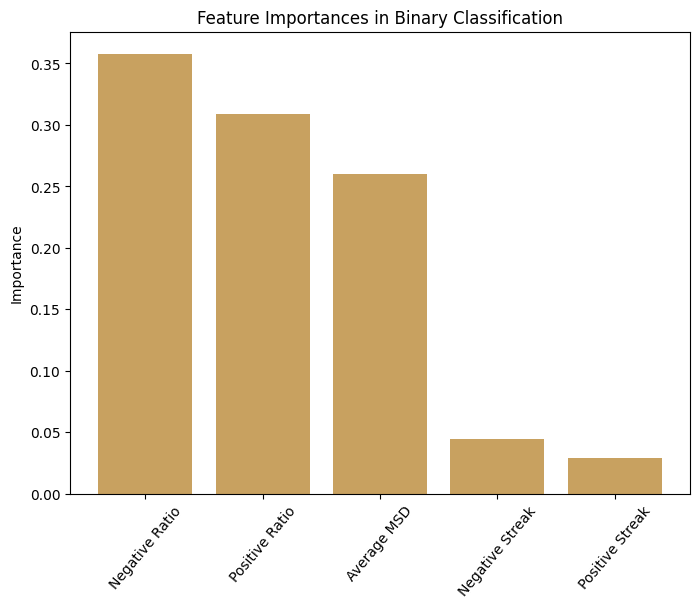

In [55]:
import matplotlib.pyplot as plt

importances = bgrids[3].feature_importances_

# Sort feature importances in descending order
indices = sorted(range(len(importances)), key=lambda i: importances[i], reverse=True)
features_impt = X_train.columns[indices]

# Print feature importances
print("Feature importances:")
for i in range(len(importances)):
    print(f"Feature {i+1}: {importances[indices[i]]:.4f} - Index: {indices[i]}")
    print(features_impt[i], )

# Visualize feature importances
plt.figure(figsize=(8, 6))
plt.title("Feature Importances in Binary Classification")
plt.bar(["Negative Ratio", "Positive Ratio", "Average MSD", "Negative Streak", "Positive Streak"], importances[indices], align="center", color='#C8A160')
plt.xticks(rotation=50)
plt.ylabel("Importance")
plt.show()

## Multilabel classification

In [56]:
def mtune(model, param_grid, X_train, y_train):
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring= make_scorer(f1_score, average='weighted'), n_jobs=-1)
    grid_search.fit(X_train, y_train)
    print('* Best hyperparameters:', grid_search.best_params_)
    print('* Best accuracy score:', grid_search.best_score_)

    return grid_search.best_estimator_

In [57]:
nb = MultinomialNB()
svm = LinearSVC()
rf = RandomForestClassifier()
lg = LogisticRegression()
models = [lg, nb, svm, rf]

param_grids = [
    {'C': [0.001, 0.01, 0.1, 1, 10], 'multi_class': ['multinomial']},
    {'alpha': [0.001, 0.01, 0.1, 1, 10]},
    {'C': [0.001, 0.01, 0.1, 1, 10], 'multi_class': ['ovr']},
    {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]}
]

mgrids = []
# Perform hyperparameter tuning for each model
for i, model in enumerate(models):
    param_grid = param_grids[i]
    print(model.__class__.__name__)

    # For common training data
    mgrids.append(mtune(model, param_grid, X_train, my_train))

LogisticRegression


/home/lunaire/Documents/College/COMP90090/env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/lunaire/Documents/College/COMP90090/env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.or

* Best hyperparameters: {'C': 10, 'multi_class': 'multinomial'}
* Best accuracy score: 0.20602604236133634
MultinomialNB
* Best hyperparameters: {'alpha': 10}
* Best accuracy score: 0.15456339543826592
LinearSVC


/home/lunaire/Documents/College/COMP90090/env/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/lunaire/Documents/College/COMP90090/env/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/lunaire/Documents/College/COMP90090/env/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/lunaire/Documents/College/COMP90090/env/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the v

* Best hyperparameters: {'C': 10, 'multi_class': 'ovr'}
* Best accuracy score: 0.23368799988456807
RandomForestClassifier
* Best hyperparameters: {'max_depth': 10, 'n_estimators': 100}
* Best accuracy score: 0.260628619030048


Feature importances:
Feature 1: 0.3325 - Index: 2
negative_ratio
Feature 2: 0.2734 - Index: 1
positive_ratio
Feature 3: 0.2677 - Index: 0
mean_msd
Feature 4: 0.0660 - Index: 4
negative_combo
Feature 5: 0.0604 - Index: 3
positive_combo


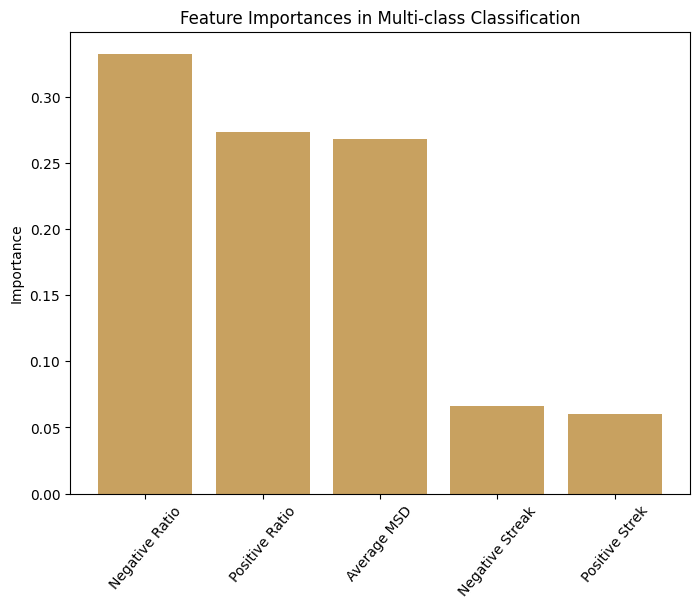

In [60]:
import matplotlib.pyplot as plt

importances = mgrids[3].feature_importances_

# Sort feature importances in descending order
indices = sorted(range(len(importances)), key=lambda i: importances[i], reverse=True)
features_impt = X_train.columns[indices]

# Print feature importances
print("Feature importances:")
for i in range(len(importances)):
    print(f"Feature {i+1}: {importances[indices[i]]:.4f} - Index: {indices[i]}")
    print(features_impt[i])

# Visualize feature importances
plt.figure(figsize=(8, 6))
plt.title("Feature Importances in Multi-class Classification")
plt.bar(["Negative Ratio", "Positive Ratio", "Average MSD",  "Negative Streak", "Positive Strek"], importances[indices], align="center", color='#C8A160')
plt.xticks(rotation=50)
plt.ylabel("Importance")
plt.show()

,Binary classification,Multi-class classification
Features,,
positive_combo,0.029206,0.060394
negative_combo,0.044360,0.066040
mean_msd,0.259683,0.267704
positive_ratio,0.308725,0.273402
negative_ratio,0.358026,0.332460


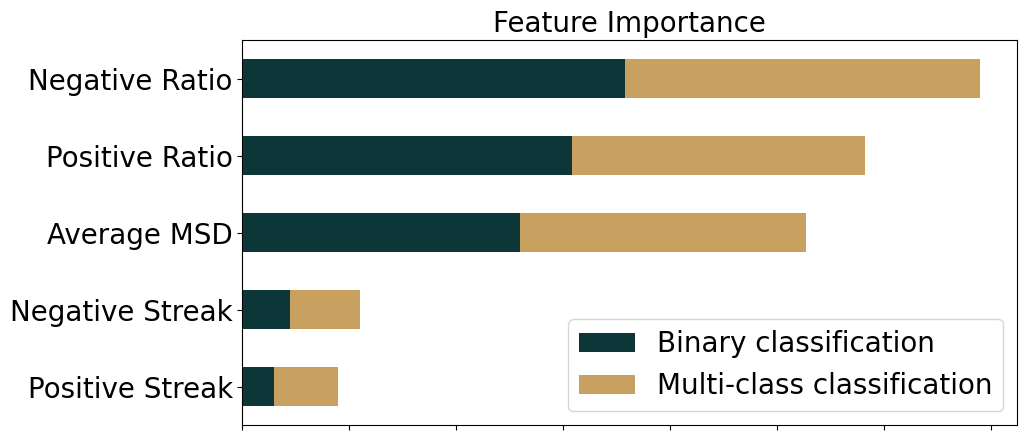

In [63]:
#Feature importance
features = X_train.columns
b_importance = bgrids[3].feature_importances_ / sum(bgrids[3].feature_importances_)
m_importance = mgrids[3].feature_importances_ / sum(bgrids[3].feature_importances_)


# Create a DataFrame for the feature importances
data = {
    'Features': features,
    'Binary classification': b_importance,
    'Multi-class classification': m_importance,
}

df = pd.DataFrame(data)

# Set the Features column as the index
df.set_index('Features', inplace=True)

# Sort the DataFrame based on the sum of feature importances across all models
df_sorted = df.sum(axis=1).sort_values()
df_sorted = df.loc[df_sorted.index]

display(df_sorted)

# Plotting the sorted stacked bar horizontal plot
ax = df_sorted.plot(kind='barh', stacked=True, figsize=(10, 5), color=['#0D3639', '#C8A160'])
ax.set_yticklabels(["Positive Streak", "Negative Streak", "Average MSD", "Positive Ratio", "Negative Ratio"], fontsize=20)
ax.set_xticklabels([])
ax.set_ylabel(None)
ax.set_title('Feature Importance', fontsize=20)
ax.legend(fontsize=20);
plt.show()

# Evaluate

In [64]:
def evaluate(y, y_pred, y_pred_proba=None):
    report = classification_report(y, y_pred)
    print('Classification Report:')
    print(report)

    if y_pred_proba is not None:
        auroc = roc_auc_score(y, y_pred_proba)
        print('AUROC:', round(auroc, 4))
    print()

    return classification_report(y, y_pred, output_dict=True)

In [65]:
breport = pd.DataFrame(columns=['P', 'R', 'F1'], index=['Logistic Regression', 'Naive Bayes', 'Support Vector Machine', 'Random Forest'])
mreport = pd.DataFrame(columns=['P', 'R', 'F1'], index=['Logistic Regression', 'Naive Bayes', 'Support Vector Machine', 'Random Forest'])

## Binary classification

In [66]:
for i, model in enumerate(bgrids):
    print("============", model.__class__.__name__, "============")
    y_pred = model.predict(X_test)
    if hasattr(model, "predict_proba"):
        report = evaluate(y_test, y_pred, model.predict_proba(X_test)[::,1])
    else:
        report = evaluate(y_test, y_pred)

    breport.iloc[i,:] = [round(report['weighted avg']['precision'],2), round(report['weighted avg']['recall'],2), round(report['weighted avg']['f1-score'],2)]

============ LogisticRegression ============
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.13      0.22      1640
           1       0.79      0.98      0.87      5339

    accuracy                           0.78      6979
   macro avg       0.72      0.56      0.55      6979
weighted avg       0.76      0.78      0.72      6979

AUROC: 0.6902

============ MultinomialNB ============
Classification Report:
              precision    recall  f1-score   support

           0       0.24      0.02      0.03      1640
           1       0.77      0.98      0.86      5339

    accuracy                           0.76      6979
   macro avg       0.50      0.50      0.45      6979
weighted avg       0.64      0.76      0.67      6979

AUROC: 0.5567

============ LinearSVC ============
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.07      0.12      1640
           1     

In [67]:
breport

,P,R,F1
Logistic Regression,0.76,0.78,0.72
Naive Bayes,0.64,0.76,0.67
Support Vector Machine,0.76,0.77,0.69
Random Forest,0.77,0.79,0.73


## Multilabel classifiction

In [68]:
for i, model in enumerate(mgrids):
    print("============", model.__class__.__name__, "============")
    my_pred = model.predict(X_test)
    report = evaluate(my_test, my_pred)

    mreport.iloc[i,:] = [round(report['weighted avg']['precision'],2), round(report['weighted avg']['recall'],2), round(report['weighted avg']['f1-score'],2)]

============ LogisticRegression ============
Classification Report:
              precision    recall  f1-score   support

        adhd       0.27      0.60      0.38      1619
     anxiety       0.15      0.01      0.02       968
     bipolar       0.00      0.00      0.00       330
  depression       0.17      0.02      0.03      1360
         mdd       0.00      0.00      0.00        65
         neg       0.32      0.63      0.43      1640
         ocd       0.00      0.00      0.00       265
         ppd       0.00      0.00      0.00        49
        ptsd       0.00      0.00      0.00       683

    accuracy                           0.29      6979
   macro avg       0.10      0.14      0.10      6979
weighted avg       0.19      0.29      0.20      6979


============ MultinomialNB ============
Classification Report:
              precision    recall  f1-score   support

        adhd       0.25      0.81      0.38      1619
     anxiety       0.21      0.12      0.15       968


In [69]:
mreport

,P,R,F1
Logistic Regression,0.19,0.29,0.2
Naive Bayes,0.15,0.24,0.16
Support Vector Machine,0.2,0.29,0.23
Random Forest,0.34,0.32,0.26


[Text(0, 0.5, 'ppd'),
 Text(0, 1.5, 'mdd'),
 Text(0, 2.5, 'ocd'),
 Text(0, 3.5, 'ptsd'),
 Text(0, 4.5, 'adhd'),
 Text(0, 5.5, 'bipolar'),
 Text(0, 6.5, 'anxiety'),
 Text(0, 7.5, 'depression'),
 Text(0, 8.5, 'neg')]

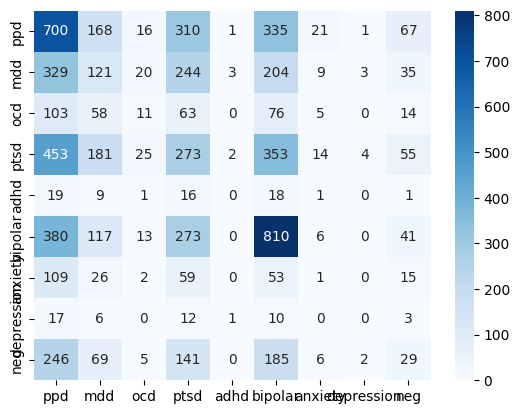

In [ ]:
# Show confustion matrix for highest accuracy score
classification_matrix = confusion_matrix(my_test, my_pred)
ax = sns.heatmap(classification_matrix, annot=True, cmap='Blues', fmt='d')
ax.set_xticklabels(LABEL)
ax.set_yticklabels(LABEL)

# Multi-output Classification

In [20]:
# Define a custom aggregation function
def aggregate_to_tuple(series):
    return tuple(series)

# Group by 'Name' and 'Age', then aggregate 'Score' into tuples using the custom function
new_data = data.groupby(['max_msd', 'mean_msd', 'positive_ratio', 'negative_ratio', 'positive_combo', 'negative_combo'])['mlabel'].agg(aggregate_to_tuple).reset_index()
new_data.head()

,max_msd,mean_msd,positive_ratio,negative_ratio,positive_combo,negative_combo,mlabel
0,0.000000,0.000000,0.000000,0.000000,0,0,"(mdd, ocd, bipolar, anxiety, depression, depre..."
1,0.000258,0.000004,0.000000,0.011236,0,0,"(neg,)"
2,0.000305,0.000006,0.004975,0.008706,0,0,"(neg,)"
3,0.000327,0.000024,0.000000,0.077419,0,0,"(neg,)"
4,0.000378,0.000037,0.033129,0.072393,0,0,"(neg,)"


In [21]:
new_data = new_data.drop([0], axis=0).reset_index(drop=True)
new_data.mlabel.apply(lambda x: len(x)).value_counts()

mlabel
1    33794
2      465
3       15
Name: count, dtype: int64

In [22]:
new_x = new_data.drop(['mlabel'], axis=1)
new_y = new_data['mlabel']

mlb = MultiLabelBinarizer()
m_ys = mlb.fit_transform(new_y)

new_x.head()

,max_msd,mean_msd,positive_ratio,negative_ratio,positive_combo,negative_combo
0,0.000258,0.000004,0.000000,0.011236,0,0
1,0.000305,0.000006,0.004975,0.008706,0,0
2,0.000327,0.000024,0.000000,0.077419,0,0
3,0.000378,0.000037,0.033129,0.072393,0,0
4,0.000437,0.000001,0.000000,0.001645,0,0


In [23]:
# First Split for Train and Test
x_train,x_test,y_train,y_test = train_test_split(new_x, m_ys, test_size=0.2, random_state=RANDOM_SEED,shuffle=True)

# Getting a sense of how the tags data looks like
print(m_ys[0])
print(mlb.inverse_transform(m_ys[0].reshape(1,-1)))
print(mlb.classes_)

[0 0 0 0 0 1 0 0 0]
[('neg',)]
['adhd' 'anxiety' 'bipolar' 'depression' 'mdd' 'neg' 'ocd' 'ppd' 'ptsd']


In [24]:
from sklearn.metrics import accuracy_score

m = MultiOutputClassifier(RandomForestClassifier(n_estimators=300))

# Fit the multi-output classifier to the training data
m.fit(x_train, y_train)

# Predict multi-output labels for test data
y_pred = m.predict(x_test)

# Evaluate the performance of the multi-output classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.06549963530269876


In [25]:
print(classification_report(mlb.transform(y_test), mlb.transform(y_pred), target_names=mlb.classes_))

              precision    recall  f1-score   support

        adhd       0.00      0.00      0.00         0
     anxiety       0.00      0.00      0.00         0
     bipolar       0.00      0.00      0.00         0
  depression       0.00      0.00      0.00         0
         mdd       0.00      0.00      0.00         0
         neg       0.00      0.00      0.00         0
         ocd       0.00      0.00      0.00         0
         ppd       0.00      0.00      0.00         0
        ptsd       0.00      0.00      0.00         0

   micro avg       0.00      0.00      0.00         0
   macro avg       0.00      0.00      0.00         0
weighted avg       0.00      0.00      0.00         0
 samples avg       0.00      0.00      0.00         0



## Random Forest Feature Importance

# BERT

In [ ]:
# Huggingface transformers
import transformers
from transformers import BertModel,BertTokenizer,AdamW, get_linear_schedule_with_warmup

import torch
from torch import nn ,cuda
from torch.utils.data import DataLoader,Dataset,RandomSampler, SequentialSampler

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint

## With features

### Model

In [26]:
x_train,x_test,y_train,y_test = train_test_split(new_x, m_ys, test_size=0.1, random_state=RANDOM_SEED,shuffle=True)
# Next split Train in to training and validation
x_tr,x_val,y_tr,y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=RANDOM_SEED,shuffle=True)

In [27]:
class MoodDataset (Dataset):
    def __init__(self,quest,tags, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.text = quest
        self.labels = tags
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, item_idx):
        text = self.text[item_idx]
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length= self.max_len,
            padding = 'max_length',
            return_token_type_ids= False,
            return_attention_mask= True,
            truncation=True,
            return_tensors = 'pt'
          )

        input_ids = inputs['input_ids'].flatten()
        attn_mask = inputs['attention_mask'].flatten()

        return {
          'input_ids': input_ids ,
          'attention_mask': attn_mask,
          'label':torch.tensor(self.labels[item_idx],dtype= torch.float)
        }

In [56]:
class MoodDataModule (pl.LightningDataModule):
    def __init__(self,x_tr,y_tr,x_val,y_val,x_test,y_test,tokenizer, batch_size=16,max_token_len=200):
        super().__init__()
        self.tr_text = x_tr
        self.tr_label = y_tr
        self.val_text = x_val
        self.val_label = y_val
        self.test_text = x_test
        self.test_label = y_test
        self.tokenizer = tokenizer
        self.batch_size = batch_size
        self.max_token_len = max_token_len

    def setup(self, stage=None):
        self.train_dataset = MoodDataset(quest=self.tr_text,  tags=self.tr_label,tokenizer=self.tokenizer,max_len= self.max_token_len)
        self.val_dataset= MoodDataset(quest=self.val_text, tags=self.val_label,tokenizer=self.tokenizer,max_len = self.max_token_len)
        self.test_dataset =MoodDataset(quest=self.test_text, tags=self.test_label,tokenizer=self.tokenizer,max_len = self.max_token_len)
        
    def train_dataloader(self):
        return DataLoader(self.train_dataset,batch_size= self.batch_size, shuffle = True , num_workers=4)

    def val_dataloader(self):
        return DataLoader (self.val_dataset,batch_size= 16)

    def test_dataloader(self):
        return DataLoader (self.test_dataset,batch_size= 16)

In [57]:
BERT_MODEL_NAME = "bert-base-cased" # we will use the BERT base model(the smaller one)
Bert_tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

In [58]:
# Initialize the parameters that will be use for training
N_EPOCHS = 12
BATCH_SIZE = 32
MAX_LEN = 300
LR = 2e-05

In [59]:
# Instantiate and set up the data_module
data_module = MoodDataModule(x_tr,y_tr, x_val, y_val,x_test,y_test, Bert_tokenizer,BATCH_SIZE,MAX_LEN)
data_module.setup()

In [46]:
# we will use the BERT base model(the smaller one)
BERT_MODEL_NAME = "bert-base-cased"

class MoodClassifier(pl.LightningModule):
    # Set up the classifier
    def __init__(self,n_classes=10,steps_per_epoch=None,n_epochs=3, lr=2e-5):
        super().__init__()

        self.bert=BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
        self.classifier=nn.Linear(self.bert.config.hidden_size,
        n_classes) 
        self.steps_per_epoch = steps_per_epoch
        self.n_epochs = n_epochs
        self.lr = lr
        self.criterion = nn.BCEWithLogitsLoss()

    def forward(self,input_ids, attn_mask):
        output = self.bert(input_ids=input_ids,attention_mask=attn_mask)
        output = self.classifier(output.pooler_output)
            
        return output

    def training_step(self,batch,batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['label']
        
        outputs = self(input_ids,attention_mask)
        loss = self.criterion(outputs,labels)
        self.log('train_loss',loss , prog_bar=True,logger=True)
        
        return {"loss" :loss, "predictions":outputs, "labels": labels }


    def validation_step(self,batch,batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['label']
        
        outputs = self(input_ids,attention_mask)
        loss = self.criterion(outputs,labels)
        self.log('val_loss',loss , prog_bar=True,logger=True)
        
        return loss

    def test_step(self,batch,batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['label']
        
        outputs = self(input_ids,attention_mask)
        loss = self.criterion(outputs,labels)
        self.log('test_loss',loss , prog_bar=True,logger=True)
        
        return loss
    
    def configure_optimizers(self):
        optimizer = AdamW(self.parameters() , lr=self.lr)
        warmup_steps = self.steps_per_epoch//3
        total_steps = self.steps_per_epoch * self.n_epochs - warmup_steps

        scheduler = get_linear_schedule_with_warmup(optimizer,warmup_steps,total_steps)

        return [optimizer], [scheduler]

In [52]:
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [47]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',# monitored quantity
    filename='QTag-{epoch:02d}-{val_loss:.2f}',
    save_top_k=3, #  save the top 3 models
    mode='min', # mode of the monitored quantity  for optimization
)

In [48]:
steps_per_epoch = len(x_tr)//BATCH_SIZE
model = MoodClassifier(n_classes=9, steps_per_epoch=steps_per_epoch,n_epochs=N_EPOCHS,lr=LR)

In [54]:
# Instantiate the Model Trainer
trainer = pl.Trainer(max_epochs = N_EPOCHS , callbacks=[checkpoint_callback])

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [55]:
trainer.fit(model, data_module)

TypeError: setup() got an unexpected keyword argument 'stage'

### Pre-process

## Raw Text